Make sure to set all parameters in this top cell. Included in the repository are the Biagi, Puech, and BSR databases. All have a minimum indexing eV of 0.001. Biagi has a maximum indexing eV of 950, BSR has a maximum indexing eV of 300, and Puech has a maximum indexing eV of 150.

In [4]:
import numpy as np
import scipy.interpolate as interpolate
import math
import re
import glob
from matplotlib import pyplot as plt
import os
import matplotlib.pylab as pylab
from mpl_toolkits.mplot3d import Axes3D

database = 'BSR' # Will use the cross-sections contained in cross-sections/{database}
eV_min = 1.36e-3      # The minimum eV addressable using this dataset
eV_max = 2.00e2     # The maximum eV addressable using this dataset
eV_steps = 1000    # The number of steps to break each cross-section LUT into
angle_min = 0.0
angle_max = 180.0
angle_steps = 180

The below cell imports the necessary files and creates the functions used to modify the GAr momentum-transfer cross-section.

In [68]:
m_e = 9.1e-31

def E_to_v(eV):
    return np.sqrt((2 * eV * 1.60218e-19) / (m_e))

# Low eV energy-independent LAr cross-sections that merge with the (single) momentum-transfer GAr cross-section at several eV (see Wojcik and Tachiya)
def liquid_sigma_e(eV, gas_sigma_p):
    if eV < 3.85:
        return 5.5e-16
    return gas_sigma_p(eV)

def liquid_sigma_p(eV, S, gas_sigma_p):
    if eV < 4.6:
        return S(eV) * 5.5e-16
    return gas_sigma_p(eV)

eV_list = np.logspace(np.log10(eV_min), np.log10(eV_max), eV_steps)
angle_list = np.linspace(angle_min, angle_max, angle_steps)
#Elastic differential cross sections
sigma_p_angle,sigma_p_eVs, sigma_p = np.loadtxt(f'diff-cross-sections/{database}/Elastic.txt', unpack=True) # m^2
reduced_list = sigma_p_eVs[::181]
#reduced_list = np.delete(reduced_list,0)
#print(len(sigma_p))
#print(len(reduced_list))
#print(reduced_list)
sigma_p *= 1e4 # to cm^2/sr
#Integrate out the /sr to cm^2
angle = 0.0
for i in np.arange(len(sigma_p)):
    angle_rad = (math.pi/180.0)*angle
    angle_1 = angle-1
    cost = (1.0 - math.cos(angle_rad))*(1.0/4.0*math.pi)
    if(angle > 0):
        cost = 2.0*math.pi*(0.25*(-math.cos((angle_1*math.pi)/90.0) - 4.0*math.cos((angle*math.pi)/180.0) + math.cos((angle*math.pi)/90.0)) + math.cos((angle_1*math.pi)/180.0))
    sigma_p[i] *= cost
    angle += 1
    if(angle == 181.0):
        angle = 0.0
#sigma_p *= 1.0/(4.0*math.pi)
#sigma_p_func = interpolate.SmoothBivariateSpline(sigma_p_angle, sigma_p_eVs, sigma_p)
#sigma_p_func = np.zeros(len(reduced_list))
sigma_p_func = np.add.reduceat(sigma_p, np.arange(0,len(sigma_p),181))
#sigma_p_func = np.delete(sigma_p_func,len(sigma_p_func)-1)
print(sigma_p_func)
#print(len(sigma_p_func))
#inelastic differential cross sections
sigma_inel_angle, sigma_inel_eVs, sigma_inel = np.loadtxt(f'diff-cross-sections/{database}/inelastic_0.txt', unpack=True)
sigma_inel *= 1e4
reduced_inel = sigma_inel_eVs[::181]
#reduced_inel = np.delete(reduced_inel,0)
#print(reduced_inel)
sigma_inel_func = np.add.reduceat(sigma_inel, np.arange(0,len(sigma_inel), 181))
#sigma_inel_func = np.delete(sigma_inel_func,len(sigma_inel_func)-1)
#print(sigma_inel_func)
angle_lists = np.arange(181)
#print(len(angle_lists))
#print(angle_lists)
counter = 0
entry = np.full((len(reduced_list), angle_steps+3),0.)
#print(entry)
for i in np.arange(len(reduced_list)):
    for j in np.arange(angle_steps+3):
        if(j == 0):
            entry[i,j] = reduced_list[i]
        elif(j == 1):
            entry[i,j] = sigma_p_func[i]
        else:
            entry[i,j] = sigma_p[counter]/sigma_p_func[i] 
            counter += 1
#print(entry)
#for i in np.arange(len(reduced_list)):
#    print(sum(entry[i]) - reduced_list[i] - entry[i,1])
#sigma_i_eVs, sigma_i = np.loadtxt(f'cross-sections/{database}/ionization_xsec.txt', unpack=True) # m^2
#sigma_i *= 1e4                                                                                   # to cm^2  
#sigma_i_func = interpolate.interp1d(sigma_i_eVs, sigma_i, kind='slinear', fill_value=(0., 0.), bounds_error=False)

# S is the structure factor of LAr (see Wojcik and Tachiya)
#S_eVs = np.array([0, 1, 2, 3, 4, 5, 6, 7])
#S = np.array([0.048, 0.055, 0.125, 0.4, 1.115, 1.29, 1.16, 1.01])
#S_func = interpolate.interp1d(S_eVs, S, kind='quadratic', fill_value=(0.048, 1), bounds_error=False)

#final_sigma_e = np.vectorize(lambda eV: liquid_sigma_e(eV, sigma_p_func))
#final_sigma_p = np.vectorize(lambda eV: liquid_sigma_p(eV, S_func, sigma_p_func))

file_list = []
avgs = np.full(3, 0.)
#Inelastic differential cross sections
level = [11,13,14]
for ex_level in [11, 13, 14]:
    file_list.append(glob.glob(f'diff-cross-sections/{database}/inelastic_{ex_level}*.txt'))

#sigma_ex = np.full((3, eV_steps, angle_steps+angle_steps), 0.)
#print(sigma_ex)
np.seterr('raise')
sigma_ex_int = np.full((3, eV_steps),0.)
sigma_ex_int_tot = np.zeros(eV_steps)
sigma_ex_tot = np.zeros((eV_steps,angle_steps))
angle_size = np.arange(len(angle_list))
eV_size = np.arange(len(eV_list))
eV_int = 0.0
#print(file_list)
sigma_level = []
energy_vals = []
sigma_func = []
total_eVs = []
for i in np.arange(3):
    file_list[i].sort()
#print(file_list)
for k, file_group in enumerate(file_list):
    file_num = 0
    reduced_eVs = [0]*len(file_group)
    #print(reduced_eVs)
    for file in file_group:
        num_files = len(file_group)
        x_temp, y_temp, z_temp = np.loadtxt(file, unpack=True)
        z_temp *= 1e4
        angle = 0
        for i in np.arange(len(z_temp)):
            angle_rad = (math.pi/180.0)*angle
            angle_1 = angle-1
            cost = (1.0 - math.cos(angle_rad))*(1.0/4.0*math.pi)
            if(angle > 0):
                cost = 2.0*math.pi*(0.25*(-math.cos((angle_1*math.pi)/90.0) - 4.0*math.cos((angle*math.pi)/180.0) + math.cos((angle*math.pi)/90.0)) + math.cos((angle_1*math.pi)/180.0))
            z_temp[i] *= cost
            angle += 1
            if(angle == 181.0):
                angle = 0.0
        reduced_eVs[file_num] = y_temp[::181]
        #reduced_inel = np.delete(reduced_inel,0)
        #print(reduced_eVs)
        sum_xsec = np.add.reduceat(z_temp, np.arange(0,len(z_temp), 181))
        #sum_xsec *= 1.0/(4.0*math.pi)
        if(file_num==0):
            min_e = y_temp[0]
            sigma_ex = [0]*num_files
            total_e_values = reduced_eVs[file_num]
            energy_vals.append(reduced_eVs[file_num])
            num_files_with_e = np.full(len(total_e_values),0.0)
            #print(len(reduced_eVs[file_num]))
            #print(len(total_e_values))
            total_eVs.append(total_e_values)
            #print(total_e_values)
        sigma_ex[file_num] = np.full((len(reduced_eVs[file_num]), angle_steps+3),0.)
        #print(sigma_ex[0][0,0])
        #sigma_inel_func = np.delete(sigma_inel_func,len(sigma_inel_func)-1)
        #print(sum_xsec)
        #angle_lists = np.arange(181)
        #print(len(angle_lists))
        #print(angle_lists)
        counter = 0
        #print(len(sigma_ex))
        for i in np.arange(len(reduced_eVs[file_num])):
            for j in np.arange(angle_steps+3):
                if(j == 0):
                    sigma_ex[file_num][i,j] = reduced_eVs[file_num][i]
                elif(j == 1):
                    sigma_ex[file_num][i,j] = sum_xsec[i]
                else:
                    sigma_ex[file_num][i,j] = z_temp[counter]/sum_xsec[i] 
                    counter += 1
        for num in np.arange(len(total_e_values)):
            e_val = total_e_values[num]
            if(e_val in sigma_ex[file_num]):
                num_files_with_e[num] += 1
        
        #print(num_files_with_e)
        #print(sigma_ex)
        #for i in np.arange(len(reduced_eVs)):
            #print(sum(sigma_ex[i]) - reduced_eVs[i] - sigma_ex[i,1])
        #prinnp.add.reduceat(z_temp, np.arange(0,len(z_temp),len(angle_list)))
       
        
        #interp_func = interpolate.interp2d(x_temp, y_temp, z_temp, kind='linear', bounds_error=False, fill_value=(0., 0.))
        #interp_func = interpolate.griddata(x_temp, y_temp, z_temp, method='linear')
        #print(interp_func)
        #interp_func = interpolate.bisplrep(x_temp, y_temp, z_temp, s=0)
        #interp_func = interpolate.SmoothBivariateSpline(x_temp, y_temp, z_temp)
        #print(interp_func(angle_list,eV_list))
        #print(float(interp_func(angle_list,eV_list)))
        file_num += 1
        avgs[k] += float(re.search(r'\d*\.\d*', file)[0])
    #print(reduced_eVs)
    #print(sigma_ex[0])
    for num in np.arange(1,num_files):
        for val in np.arange(len(reduced_eVs[num])):
            e_val = reduced_eVs[0][val]
            if(e_val in sigma_ex[num]):
                #for i in np.arange(len(reduced_eVs[num])):
                    #for j in np.arange(angle_steps+3):
                        #if(j != 0):
                sigma_ex[0][val] += sigma_ex[num][val]
    print(len(reduced_eVs[0]))
    for val in np.arange(len(total_e_values)):
        sigma_ex[0][val] /= num_files_with_e[val]
    sigma_func.append(np.zeros(len(reduced_eVs[0])))
    for val in np.arange(len(total_e_values)):
        sigma_func[k][val] = sigma_ex[0][val,1]
    #print(len(sigma_func[k]))
    #print(sigma_ex[0])
        #for i in eV_size:
        #    for j in angle_size:
        #        eV_int += float(interp_func(angle_list[j],eV_list[i])) * 1e4
                #sigma_ex[k] += interp_func(eV_list) * 1e4
        #        sigma_ex[k,j,i] += float(interp_func(angle_list[j], eV_list[i])) * 1e4
            #print(eV_int)
        #    sigma_ex_int[k,i] += eV_int
        #    sigma_ex_tot += eV_int
            #eV_int = 0.
        #sigma_ex_int[k] += interp_func(eV_list) * 1e4
        #sigma_ex_int_tot += float(interp_func(angle_list, eV_list)) * 1e4
        #sigma_ex_tot += interp_func(eV_list) * 1e4
    sigma_level.append(sigma_ex[0])
    #print(sigma_ex)
    #avgs[k] /= len(file_group)
#print(sigma_level)
#print(sigma_func)
#print(sigma_ex_int)

[3.94233591e-16 3.85411863e-16 3.78712154e-16 3.71170046e-16
 3.60508265e-16 3.51439843e-16 3.45170339e-16 3.35779619e-16
 3.29915662e-16 3.23098210e-16 3.16663573e-16 3.09781324e-16
 3.16386544e-16 3.07899178e-16 3.01165747e-16 2.96023610e-16
 2.88638378e-16 2.81211013e-16 2.75339218e-16 2.69357186e-16
 2.08900245e-16 1.59115584e-16 1.19537023e-16 8.92636134e-17
 6.63149496e-17 4.95274776e-17 3.71828309e-17 2.80714305e-17
 2.16141803e-17 1.71999691e-17 1.41148411e-17 1.20564349e-17
 1.09539044e-17 1.05439366e-17 1.07198914e-17 1.13980129e-17
 1.25336643e-17 1.40041112e-17 1.58986298e-17 1.79513012e-17
 2.04448465e-17 2.31741256e-17 2.57665269e-17 2.89593861e-17
 3.21837358e-17 3.54380333e-17 3.83709686e-17 4.18675771e-17
 4.52851482e-17 4.86109744e-17 5.18843055e-17 5.50948178e-17
 5.82891253e-17 6.14496090e-17 6.45446676e-17 6.76267835e-17
 7.06533213e-17 7.36571808e-17 1.02065552e-16 1.28098692e-16
 1.51781252e-16 1.73384486e-16 1.93806771e-16 2.13185899e-16
 2.31921902e-16 2.509125

The below cell condenses the given excitation cross-sections into four energy bands.

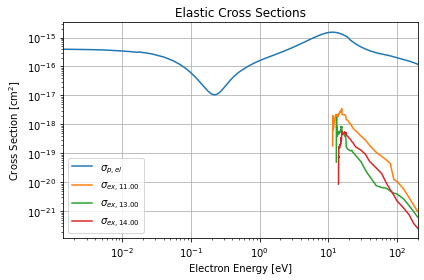

In [69]:
plt.plot(reduced_list, sigma_p_func, label=r'$\sigma_{p,el}$')
#plt.plot(reduced_inel, sigma_inel_func, label=r'$\sigma_{p,inel}$')
for k in np.arange(len(sigma_func)):
    plt.plot(total_eVs[k], sigma_func[k], label=f'$\sigma_{{ex,{level[k]:.2f}}}$')

#plt.plot(eV_list, sigma_ex_int_tot, 'g', label='$\sigma_{ex,tot}$')
eV_min = min(reduced_list)
eV_max = max(reduced_list)
plt.xlim(eV_min, eV_max)

plt.xlabel('Electron Energy [eV]')
plt.ylabel('Cross Section [cm$^2$]')

#plt.title('Excitation Cross Sections')
plt.title('Elastic Cross Sections')

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

The cell below show all cross-sections together.

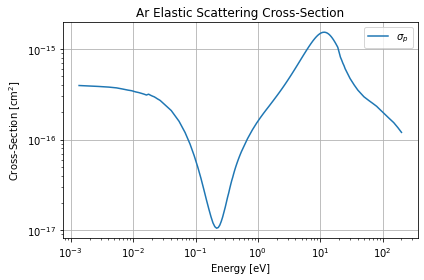

In [59]:
plt.plot(reduced_list, sigma_p_func, label=r'$\sigma_p$')
#plt.plot(eV_list, final_sigma_e(eV_list), label=r'LAr $\sigma_E$')
#plt.plot(eV_list, final_sigma_p(eV_list), label=r'LAr $\sigma_p$')

#plt.plot(eV_list, sigma_i_func(eV_list), label=r'$\sigma_I$')

#for k, ex_level in enumerate(sigma_ex):
#    plt.plot(eV_list, ex_level, label=f'$\sigma_{{ex,{avgs[k]:.2f}}}$')

plt.xlabel('Energy [eV]')
plt.ylabel(r'Cross-Section [cm$^2$]')

plt.title('Ar Elastic Scattering Cross-Section')

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

The below cell calculates and shows each cross-section multiplied by the electron velocity corresponding to the $x$-axis kinetic energy. These values are used to calculate the probability of scattering events. $K_\mathrm{max}$ is taken to be the peak of the sum of these values.

In [60]:
#compos_x_sec = np.array([])
#for i, e in enumerate(eV_list):
#    compos_x_sec = np.append(compos_x_sec, max(final_sigma_e(e), final_sigma_p(e) + sigma_ex_tot[i]))

#plt.plot(eV_list, sigma_p_func(eV_list) * E_to_v(eV_list) * 1e2, label=r'GAr $v\sigma_p$')
#plt.plot(eV_list, (sigma_p_func(eV_list) + sigma_ex_tot) * E_to_v(eV_list) * 1e2, label=r'GAr $v\sigma_{total}$')

#plt.plot(eV_list, compos_x_sec * E_to_v(eV_list) * 1e2, label=r'$v\sigma_{total}$')

#plt.plot(eV_list, final_sigma_e(eV_list) * E_to_v(eV_list) * 1e2, label=r'$v\sigma_E$')
#plt.plot(eV_list, final_sigma_p(eV_list) * E_to_v(eV_list) * 1e2, label=r'$v\sigma_p$')

#plt.plot(eV_list, sigma_i_func(eV_list) * E_to_v(eV_list) * 1e2, label=r'$v\sigma_I$')
#plt.plot(eV_list, sigma_ex[0] * E_to_v(eV_list) * 1e2, label=r'$v\sigma_{e_{11}}$')
#plt.plot(eV_list, sigma_ex[1] * E_to_v(eV_list) * 1e2, label=r'$v\sigma_{e_{13}}$')
#plt.plot(eV_list, sigma_ex[2] * E_to_v(eV_list) * 1e2, label=r'$v\sigma_{e_{14}}$')
#plt.plot(eV_list, sigma_ex[3] * E_to_v(eV_list) * 1e2, label=r'$v\sigma_{e_{15}}$')

#plt.xlabel('Energy [eV]')
#plt.ylabel(r'Velocity $\times$ Cross-Section [cm$^3$/s]')

#K_max = round(np.amax(compos_x_sec * E_to_v(eV_list) * 1e2) * 1.01, 9)
#plt.plot(np.logspace(-3, 3, 10), np.full(10, K_max), 'k--', label='$K_{\mathrm{max}}$')
#plt.title(f'Determination of $K_{{\mathrm{{max}}}}$')

#plt.xscale('log')
#plt.yscale('log')

#plt.legend(loc=3)
#plt.grid()
#plt.tight_layout()
#plt.show()

This final cell generates the LUTs used by the simulation.

In [61]:
if os.path.exists("../../src/LUTs/DiffCrossSections.h"):
    os.remove("../../src/LUTs/DiffCrossSections.h")

header = open("../../src/LUTs/DiffCrossSections.h", "a+")

np.savetxt(header, [], comments="", header=f"#ifndef DIFFCROSSSECTIONS_H\n#define DIFFCROSSSECTIONS_H\n\nconst double eV_min = {eV_min};\nconst double eV_max = {eV_max};\nconst int eV_steps = {eV_steps};\n");#\nconst double K_max = {K_max};\n\nconst double effective_xsec_liquid[] = {{")
#np.savetxt(header, final_sigma_e(eV_list), newline=",")
#np.savetxt(header, [], comments="", header="\n};\n\nconst double momentum_xsec_liquid[] = {")
#np.savetxt(header, final_sigma_p(eV_list), newline=",")
np.savetxt(header, [], comments="", header="\n\nconst double energy_vals[] = {")
np.savetxt(header,reduced_list, newline=",")
np.savetxt(header, [], comments="", header="\n};\n\nconst double momentum_xsec_gas[][] = {")
for i in np.arange(len(entry)):
    np.savetxt(header, entry[i], newline=",")
np.savetxt(header, [], comments="", header="\n};\n\nconst double excite_xsec_11[] = {")
for i in np.arange(len(sigma_level[0])):
    np.savetxt(header, sigma_level[0][i], newline=",")
np.savetxt(header, [], comments="", header="\n};\n\nconst double excite_xsec_13[] = {")
for i in np.arange(len(sigma_level[1])):
    np.savetxt(header, sigma_level[1][i], newline=",")
np.savetxt(header, [], comments="", header="\n};\n\nconst double excite_xsec_14[] = {")
for i in np.arange(len(sigma_level[2])):
    np.savetxt(header, sigma_level[2][i], newline=",")
#np.savetxt(header, [], comments="", header="\n};\n\nconst double excite_xsec_15[] = {")
#np.savetxt(header, sigma_ex[3], newline=",")
#np.savetxt(header, [], comments="", header="\n};\n\nconst double ionization_xsec[] = {")
#np.savetxt(header, sigma_i_func(eV_list), newline=",")
np.savetxt(header, [], comments="", header="\n};\n\n#endif")

header.close()